Copy Contents to starter.py for submission

In [35]:
# Imports
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
import matplotlib.pyplot as plt

In [36]:
# Encoding and decoding
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    
    if threshold > -1:
        with open(file_name,'rt', encoding='utf8') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt', encoding='utf8') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

def plot_data(x, y, xlabel, ylabel):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [37]:
# CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [38]:
# FeedForward Model
class FFNN(nn.Module):
    def __init__(self, vocab, words, d_model, d_hidden, dropout):
        super().__init__() 
    
        # Class parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.dropout = dropout

        # Embedding Layer
        self.embeds = nn.Embedding(self.vocab_size, self.d_model)

        # Linear Layers
        self.fc1 = nn.Linear(880 * d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, 2)

        # Nonlinear Layer
        self.activation = nn.Tanh()

        # Setting weights
        self.init_weights()
                
    # Initialize weights for foward layer
    def init_weights(self):
        weight_range = 0.1
        self.embeds.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.bias.data.zero_()

    # Forward
    def forward(self, src):
        # Embeddings are fed into the forward layer
        embeds = self.embeds(src).view((-1, 880 * self.d_model))
        x = self.activation(self.fc1(embeds))
        x = self.fc2(x)
        # probs = nn.Softmax(x)
        # print("probs", probs)
        # return probs
        return x

In [39]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self,vocab,words,d_model,d_hidden,n_layers,dropout_rate):
        super().__init__()
        
        # Class Parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.n_layers = n_layers
        self.d_hidden = d_hidden
        self.d_model = d_model

        # Embedding Layer
        self.embeds = nn.Embedding(self.vocab_size,self.d_model)
        
    # Forward
    def forward(self,src,h):
        embeds = self.dropout(self.embeds(src))       
        return [preds,h]
    
    def init_weights(self):
        pass        
    
    def detach_hidden(self, hidden):
        return [hidden, cell]

In [40]:
# Preprocessing
def process_data(data):
    fake_i = (data == 122)
    real_i = (data == 635)
    target_indices = (fake_i + real_i).nonzero()
    num_entries = len(target_indices)
    bio_tensor_list = []
    target_list = []
    entry = 0
    start_i = 0

    while entry < num_entries:
        target_i = target_indices[entry]
        # Size of data and targets
        #print(f"Data size: {data[start_i:target_i].size()}")
        #print(f"Target size: {data[target_i].size()}")

        # Take in a list of tensors and use pad sequence
        bio = data[start_i:target_i]
        target = [1, 0] if data[target_i] == 122 else [0, 1]
        # target = data[target_i]

        bio_tensor_list.append(torch.tensor(bio).squeeze())
        target_list.append(target)

        start_i = target_i + 1
        entry += 1

    padded_bios = torch.t(pad_sequence(bio_tensor_list))
    print("First bio", padded_bios[0].size())
    print("Second bio", padded_bios[1].size())
    return padded_bios, torch.tensor(target_list)

In [41]:
# Train Model Function
def train_model(model, data, targets, optimizer):
        print(data.size())
        model.train()
        optimizer.zero_grad()

        logit_output = model(data).squeeze()
        probs = torch.softmax(logit_output, dim=1)

        # Shapes of output and targets
        print(f"Output size: {probs.size()}")
        print(f"Target size: {targets.size()}")

        # loss = F.mse_loss(output.float(), targets.float())
        # output = torch.argmax(output, dim=1)
        loss = F.binary_cross_entropy(probs.float(), targets.float())
        print("Loss:", loss)
        loss.backward()

        optimizer.step()

        return loss

def train_loop(model, features, targets, epochs, optimizer):
    losses = []
    epoch_list = []
    for epoch in range(0, epochs):
        loss = train_model(model, features, targets, optimizer)
        print(epoch)
        epoch_list.append(epoch)
        losses.append(loss.item())
    plot_data(epoch_list, losses, 'Loss', 'Epoch')

In [42]:
class Params:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [43]:
model_map = {0: 'FFNN', 1: 'LSTM', 2: 'FFNN_CLASSIFY', 3: 'LSTM_CLASSIFY'}
train_map = {0: 'data/real.train.tok', 1: 'data/fake.train.tok', 2: 'data/mix.train.tok'}
valid_map = {0: 'data/real.valid.tok', 1: 'data/fake.valid.tok', 2: 'data/mix.valid.tok'}
test_map = {0: 'data/real.test.tok', 1: 'data/fake.test.tok', 2: 'data/mix.test.tok', 3: 'data/blind.test.tok'}

model_type = model_map[0]
# train_type = [train_map[0], train_map[1]]

# Types of data
train_type = train_map[2]
valid_type = valid_map[0]
test_type = test_map[0]

args = {
    "d_model": 1,
    "d_hidden": 2,
    "n_layers": 3,
    "batch_size": 20,
    "seq_len": 30,
    "printevery": 5000,
    "window": 3,
    "epochs": 20,
    "lr": 0.0001,
    "dropout": 0.35,
    "clip": 2.0,
    "model": model_type,
    "savename": model_type.lower(),
    "loadname": model_type.lower(),
    "trainname": train_type,
    "validname": valid_type,
    "testname": test_type
}

In [44]:
# Main Function
def main(args): 
    torch.manual_seed(0)
    
    params = Params(**args)
    train_name = params.trainname
    test_name = params.testname
    model_type = params.model
    d_mod = params.d_model
    d_hid = params.d_hidden
    dropout = params.dropout
    epochs = params.epochs

    # real, fake = params.trainname
    # [vocab_real, words_real, train_real] = read_encode(real, [], {}, [], 3)
    # [vocab_fake, words_fake, train_fake] = read_encode(fake, [], {}, [], 3)

    # train_features = torch.cat((torch.tensor(train_real), torch.tensor(train_fake)))
    # train_labels = torch.cat((torch.ones(len(train_real)), torch.zeros(len(train_fake))))
    # print(f'train_features: {train_features}')
    # print(f'train_labels: {train_labels}')

    [vocab,words,train] = read_encode(train_name,[],{},[],3)
    train_data = torch.tensor(train)
    
    # print('vocab: %d train: %d' % (len(vocab),len(train)))
    # print(f'vocab: {vocab[10:20]}\n \n train: {train[10:20]}')
    # print(f'fake id: {words["[FAKE]"]}')
    # print(f'real id: {words["[REAL]"]}')

    [vocab,words,test] = read_encode(test_name,vocab,words,[],-1)
    test_data = torch.tensor(test)

    #print('vocab: %d test: %d' % (len(vocab),len(test)))
    vocab_size = len(vocab)
    train_features, train_targets = process_data(train_data)
    #test_features, test_targets = process_data(test_data)
    
    if model_type == 'FFNN':
        ffnn_model = FFNN(vocab, words, d_mod, d_hid, dropout)
        optimizer = torch.optim.SGD(ffnn_model.parameters(), lr=0.01, momentum=0.9)
        train_loop(ffnn_model, train_features, train_targets, epochs, optimizer)
        pass
        # print(ffnn_model)
#          {add code to instantiate the model, train for K epochs and save model to disk}
        
    if model_type == 'LSTM':
        pass
#          {add code to instantiate the model, train for K epochs and save model to disk}

    if model_type == 'FFNN_CLASSIFY':
        pass
#          {add code to instantiate the model, recall model parameters and perform/learn classification}    

    if model_type == 'LSTM_CLASSIFY':
        pass
#          {add code to instantiate the model, recall model parameters and perform/learn classification}


C:\Users\zarif_vfgx7yn\AppData\Local\Temp\ipykernel_7036\508513551.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_tensor_list.append(torch.tensor(bio).squeeze())


First bio torch.Size([880])
Second bio torch.Size([880])
torch.Size([7962, 880])
Output size: torch.Size([7962, 2])
Target size: torch.Size([7962, 2])
Loss: tensor(0.7095, grad_fn=<BinaryCrossEntropyBackward0>)
0
torch.Size([7962, 880])
Output size: torch.Size([7962, 2])
Target size: torch.Size([7962, 2])
Loss: tensor(0.7092, grad_fn=<BinaryCrossEntropyBackward0>)
1
torch.Size([7962, 880])
Output size: torch.Size([7962, 2])
Target size: torch.Size([7962, 2])
Loss: tensor(0.7085, grad_fn=<BinaryCrossEntropyBackward0>)
2
torch.Size([7962, 880])
Output size: torch.Size([7962, 2])
Target size: torch.Size([7962, 2])
Loss: tensor(0.7076, grad_fn=<BinaryCrossEntropyBackward0>)
3
torch.Size([7962, 880])
Output size: torch.Size([7962, 2])
Target size: torch.Size([7962, 2])
Loss: tensor(0.7065, grad_fn=<BinaryCrossEntropyBackward0>)
4
torch.Size([7962, 880])
Output size: torch.Size([7962, 2])
Target size: torch.Size([7962, 2])
Loss: tensor(0.7053, grad_fn=<BinaryCrossEntropyBackward0>)
5
torch.S

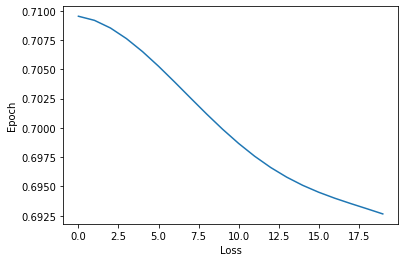

In [45]:
main(args)